<a href="https://colab.research.google.com/github/Luthragon/Machine-Learning-For-Automated-Image-Captioning-/blob/main/Automated%20Image%20Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [ ]:
# Import Library 
import numpy as np
import pandas as pd
import zipfile, os # library untuk mendownload zipfile
import cv2
import os

from glob import glob 
from skimage import io
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

# **Data Collection**

In [ ]:
# Mendownload dataset menggunakan wget

!wget --no-check-certificate \
  https://dl.dropbox.com/s/rems3rh5a96023s/Flickr_Data.zip?dl=2 \
  -O /archive.zip

--2021-03-23 13:43:50--  https://dl.dropbox.com/s/rems3rh5a96023s/Flickr_Data.zip?dl=2
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.64.15, 2620:100:6020:15::a27d:400f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.64.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/rems3rh5a96023s/Flickr_Data.zip?dl=2 [following]
--2021-03-23 13:43:50--  https://dl.dropboxusercontent.com/s/rems3rh5a96023s/Flickr_Data.zip?dl=2
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.64.15, 2620:100:6020:15::a27d:400f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.64.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1114560631 (1.0G) [application/zip]
Saving to: ‘/archive.zip’

/archive.zip        100%[===================>]   1.04G  23.7MB/s    in 50s     

2021-03-23 13:44:41 (21.2 MB/s) - ‘/archive.zip’ saved [1114560631/1114560631]



In [ ]:
# Mengekstrak folder zip yang telah terdownload
local_zip = '/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()
 
base_dir = '/archive'

# **Data Preprocessing**

In [ ]:
images_path = '/Flickr_Data/Images/'
images = glob(images_path+'*.jpg')
len(images)

8091

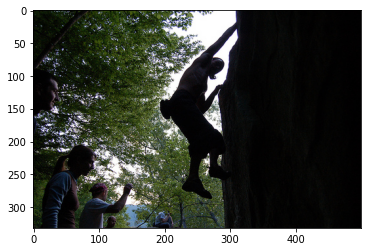

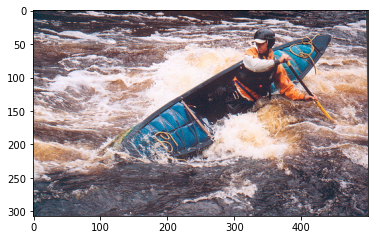

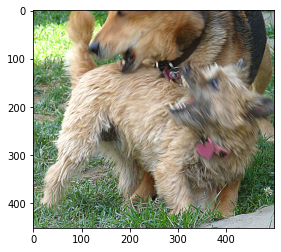

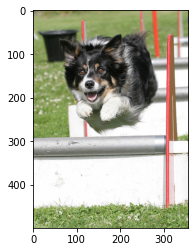

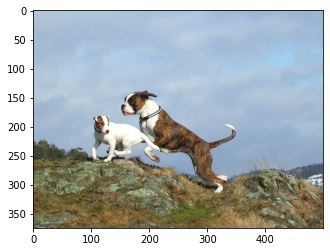

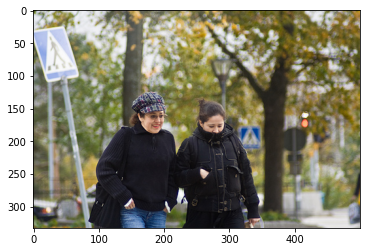

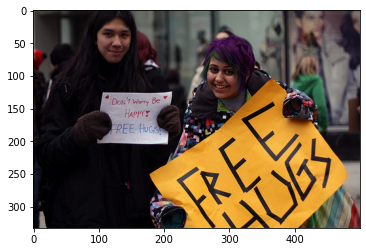

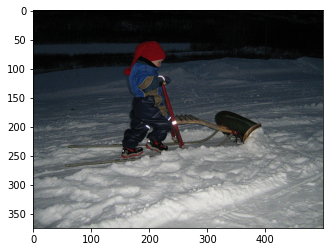

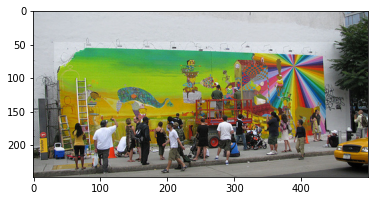

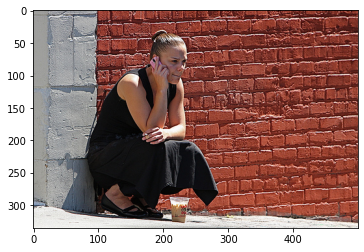

In [ ]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    brightness_range=[0.0,1.5],
    zoom_range=[0.5, 1.5],
    horizontal_flip=True,
    fill_mode='reflect'
)

In [ ]:
aug = io.imread(images[i])
aug = aug.reshape((1, ) + aug.shape)

In [ ]:
i = 0
for batch in datagen.flow(aug,batch_size=16,
                          save_to_dir=images_path,
                          save_prefix='aug',
                          save_format='jpg'):
    i += 1
    if i > 16:
        break


In [ ]:
#total keseluruhan
images_path = '/Flickr_Data/Images/'
images = glob(images_path+'*.jpg')
len(images)

8108

In [ ]:
images_path = '/Flickr_Data/Images/'
images_aug = glob(images_path+'aug_*')
len(images_aug)

17

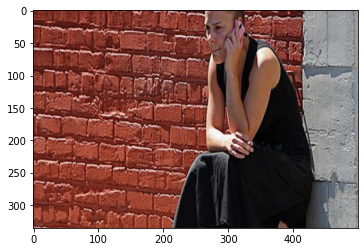

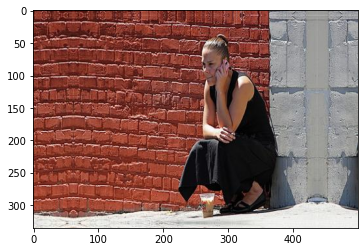

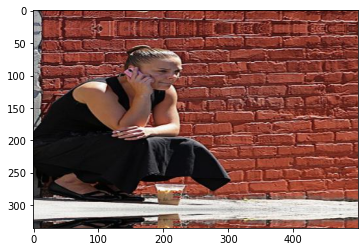

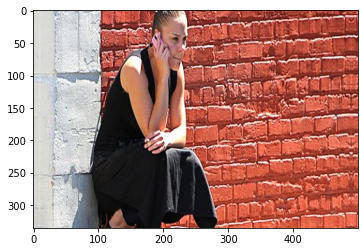

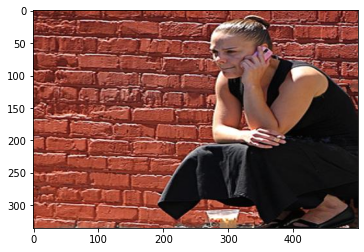

In [ ]:
for i in range(5):
    plt.figure()
    img = cv2.imread(images_aug[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

## **Image Processing**

In [ ]:
from keras.applications import ResNet50

incept_model = ResNet50(include_top=True)

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 1499:
        break
        
    elif count % 50 == 0:
        print(count)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [ ]:
len(images_features)

1500

## **Text Preprocess**

In [ ]:
caption_path = '/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [ ]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [ ]:
len(captions)

40461

In [ ]:
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [ ]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
            
    except:
        pass

In [ ]:
len(captions_dict)

1499

# **Visualize Images with captions**

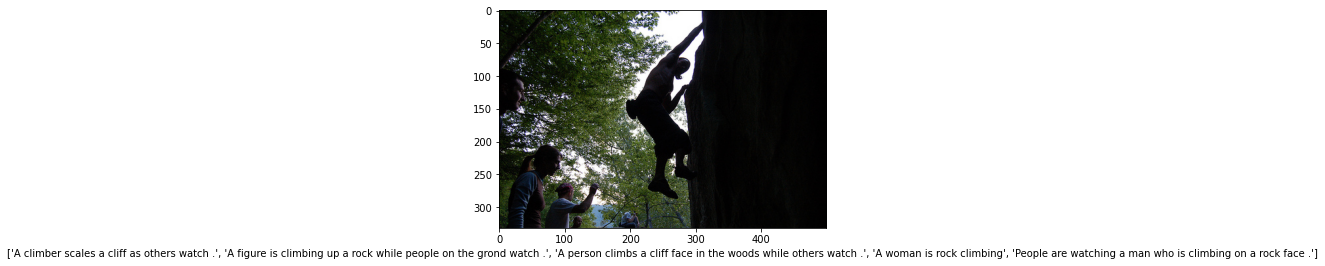

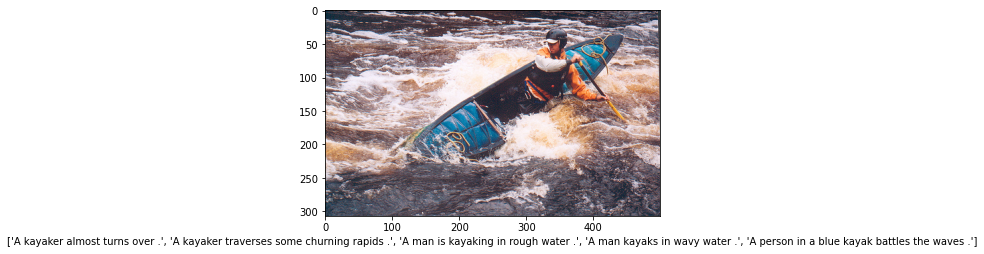

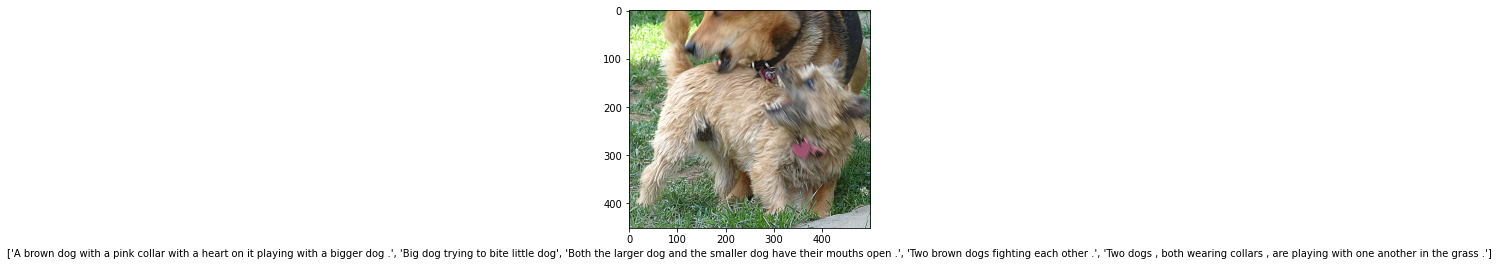

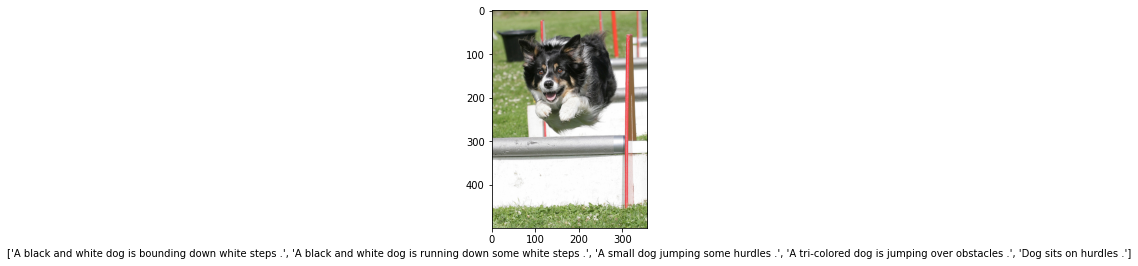

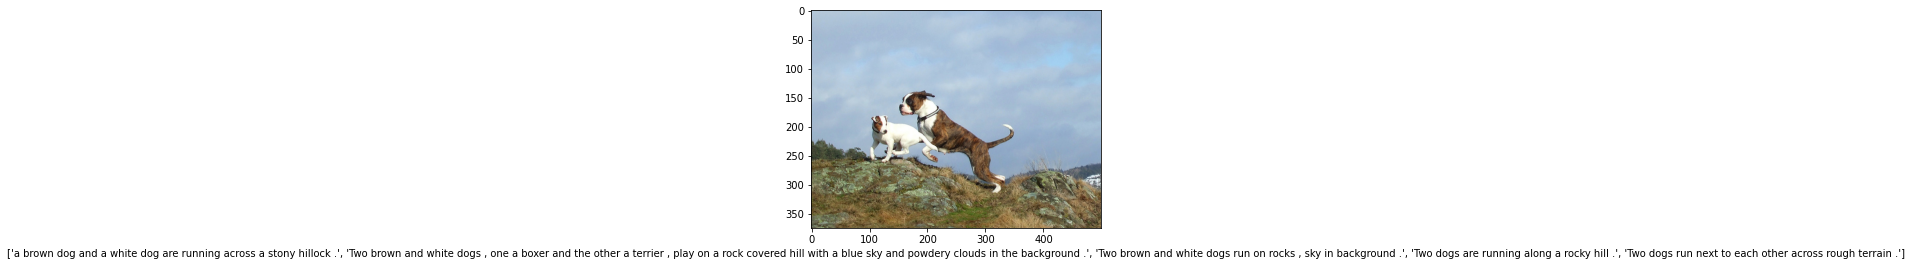

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img_name = images[i]
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

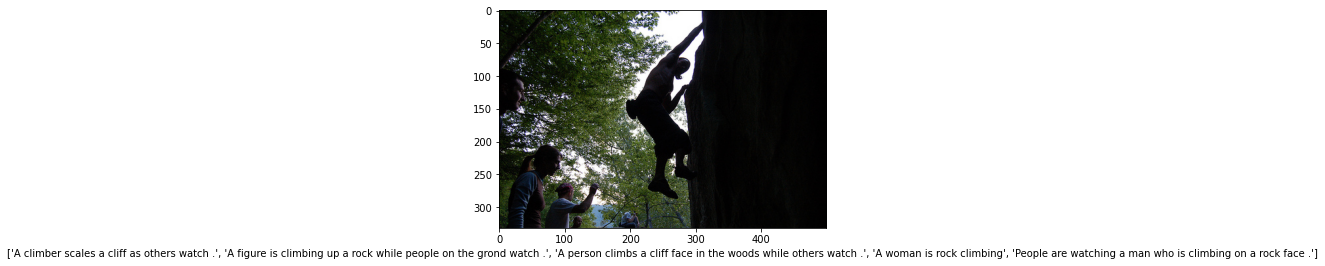

In [ ]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()
    
    img_name = '/Flickr_Data/Images/' + k
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)
    
    break

In [ ]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified    

In [ ]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

# **Create Vocabulary**

In [ ]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

In [ ]:
len(count_words)

4021

In [ ]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1
        

In [ ]:
len(new_dict)

4021

In [ ]:
new_dict['<OUT>'] = len(new_dict) 

In [ ]:
captions_backup = captions_dict.copy()

In [ ]:
captions_dict = captions_backup.copy()

In [ ]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():  
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded

In [ ]:
captions_dict

{'1000268201_693b08cb0e.jpg': [[1,
   2,
   3,
   4,
   2,
   5,
   6,
   7,
   8,
   9,
   2,
   10,
   11,
   12,
   4,
   13,
   14,
   15,
   16,
   17],
  [1, 2, 18, 19, 20, 2, 21, 22, 16, 17],
  [1, 2, 23, 18, 8, 20, 2, 21, 24, 16, 17],
  [1, 2, 23, 18, 8, 25, 12, 26, 27, 24, 16, 17],
  [1, 2, 23, 18, 4, 2, 5, 6, 19, 20, 2, 21, 28, 16, 17]],
 '1001773457_577c3a7d70.jpg': [[1, 2, 29, 30, 31, 2, 32, 30, 33, 34, 17],
  [1, 2, 29, 30, 31, 2, 35, 30, 36, 37, 38, 39, 40, 25, 41, 16, 17],
  [1,
   2,
   29,
   30,
   31,
   2,
   42,
   30,
   37,
   43,
   44,
   33,
   45,
   46,
   38,
   39,
   4,
   25,
   47,
   16,
   17],
  [1, 48, 49, 11, 50, 51, 52, 46, 38, 39, 40, 25, 41, 16, 17],
  [1, 48, 49, 40, 53, 54, 55, 38, 39, 16, 17]],
 '1012212859_01547e3f17.jpg': [[1,
   2,
   30,
   56,
   57,
   58,
   59,
   25,
   60,
   61,
   2,
   62,
   63,
   64,
   26,
   65,
   16,
   17],
  [1, 2, 42, 30, 56, 40, 25, 66, 11, 2, 67, 37, 13, 68, 63, 16, 17],
  [1, 30, 37, 68, 63, 46, 69, 

------------------------------------------------------------------------------------------------------

# **Build Generator Function**

In [ ]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)

[1, 2, 3, 4, 2, 5, 6, 7, 8, 9, 2, 10, 11, 12, 4, 13, 14, 15, 16, 17]
[1, 2, 29, 30, 31, 2, 42, 30, 37, 43, 44, 33, 45, 46, 38, 39, 4, 25, 47, 16, 17]
[1, 2, 116, 79, 128, 40, 25, 129, 132, 25, 127, 37, 2, 133, 134, 135, 4, 130, 11, 136, 16, 17]
[1, 2, 204, 4, 2, 205, 104, 31, 103, 206, 7, 8, 13, 207, 62, 100, 208, 119, 2, 209, 210, 16, 17]
[1, 2, 204, 119, 2, 96, 6, 7, 240, 2, 131, 11, 2, 102, 31, 2, 18, 40, 25, 245, 37, 245, 237, 16, 17]
[1, 2, 79, 396, 4, 2, 42, 104, 61, 96, 374, 397, 124, 119, 738, 61, 198, 2, 62, 31, 42, 739, 134, 740, 16, 17]
[1, 2, 204, 4, 13, 68, 229, 31, 668, 7, 859, 40, 2, 212, 100, 124, 2, 192, 204, 4, 2, 62, 97, 70, 64, 26, 27, 40, 25, 100, 860, 27, 861, 862, 17]
[1, 2, 23, 102, 377, 2, 1750, 666, 180, 25, 1924, 40, 2, 521, 317, 282, 119, 2, 62, 104, 61, 42, 206, 61, 31, 96, 401, 402, 884, 33, 2258, 418, 180, 136, 16, 17]


In [ ]:
MAX_LEN

36

In [ ]:
captions_dict

{'1000268201_693b08cb0e.jpg': [[1,
   2,
   3,
   4,
   2,
   5,
   6,
   7,
   8,
   9,
   2,
   10,
   11,
   12,
   4,
   13,
   14,
   15,
   16,
   17],
  [1, 2, 18, 19, 20, 2, 21, 22, 16, 17],
  [1, 2, 23, 18, 8, 20, 2, 21, 24, 16, 17],
  [1, 2, 23, 18, 8, 25, 12, 26, 27, 24, 16, 17],
  [1, 2, 23, 18, 4, 2, 5, 6, 19, 20, 2, 21, 28, 16, 17]],
 '1001773457_577c3a7d70.jpg': [[1, 2, 29, 30, 31, 2, 32, 30, 33, 34, 17],
  [1, 2, 29, 30, 31, 2, 35, 30, 36, 37, 38, 39, 40, 25, 41, 16, 17],
  [1,
   2,
   29,
   30,
   31,
   2,
   42,
   30,
   37,
   43,
   44,
   33,
   45,
   46,
   38,
   39,
   4,
   25,
   47,
   16,
   17],
  [1, 48, 49, 11, 50, 51, 52, 46, 38, 39, 40, 25, 41, 16, 17],
  [1, 48, 49, 40, 53, 54, 55, 38, 39, 16, 17]],
 '1012212859_01547e3f17.jpg': [[1,
   2,
   30,
   56,
   57,
   58,
   59,
   25,
   60,
   61,
   2,
   62,
   63,
   64,
   26,
   65,
   16,
   17],
  [1, 2, 42, 30, 56, 40, 25, 66, 11, 2, 67, 37, 13, 68, 63, 16, 17],
  [1, 30, 37, 68, 63, 46, 69, 

In [ ]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out

In [ ]:
X, y_in, y_out = generator(images_features, captions_dict)

In [ ]:
len(X), len(y_in), len(y_out)

(96118, 96118, 96118)

In [ ]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')



In [ ]:
X.shape, y_in.shape, y_out.shape

((96118, 2048), (96118, 36), (96118, 4022))

In [ ]:
X[1510]

array([1.5838059 , 2.122033  , 0.        , ..., 1.6103196 , 0.16440612,
       0.3053024 ], dtype=float32)

In [ ]:
y_in[2]

array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

# **Modelling**

In [ ]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 36, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 128)           514816    
_________________________________________________________________
lstm (LSTM)                  (None, 36, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 36, 128)           32896     
Total params: 941,952
Traina

In [ ]:
model.fit([X, y_in], y_out, batch_size=512, epochs=100)

Epoch 1/100
188/188 [==============================] - 35s 186ms/step - loss: 5.0076 - accuracy: 0.1601
Epoch 2/100
188/188 [==============================] - 35s 185ms/step - loss: 4.5074 - accuracy: 0.2413
Epoch 3/100
188/188 [==============================] - 35s 185ms/step - loss: 4.3160 - accuracy: 0.2610
Epoch 4/100
188/188 [==============================] - 35s 185ms/step - loss: 4.1805 - accuracy: 0.2718
Epoch 5/100
188/188 [==============================] - 35s 185ms/step - loss: 4.0504 - accuracy: 0.2857
Epoch 6/100
188/188 [==============================] - 35s 185ms/step - loss: 3.9312 - accuracy: 0.2958
Epoch 7/100
188/188 [==============================] - 35s 185ms/step - loss: 3.7928 - accuracy: 0.3074
Epoch 8/100
188/188 [==============================] - 35s 185ms/step - loss: 3.6518 - accuracy: 0.3223
Epoch 9/100
188/188 [==============================] - 35s 184ms/step - loss: 3.5037 - accuracy: 0.3392
Epoch 10/100
188/188 [==============================] - 35s 184m

In [ ]:
inv_dict = {v:k for k, v in new_dict.items()}

In [ ]:
model.save('model.h5')

In [ ]:
model.save_weights('mine_model_weights.h5')

In [ ]:
np.save('vocab.npy', new_dict)

In [ ]:
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

# **Predictions**

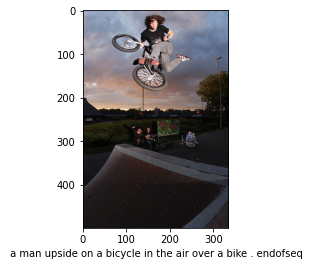

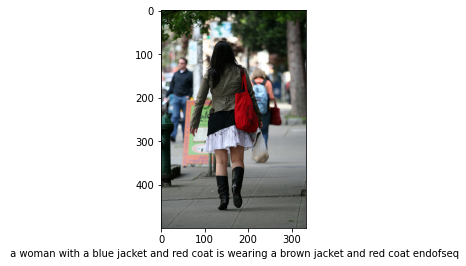

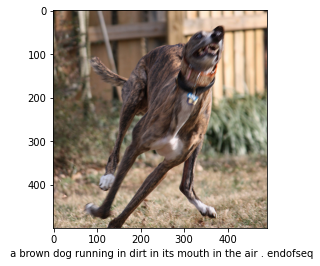

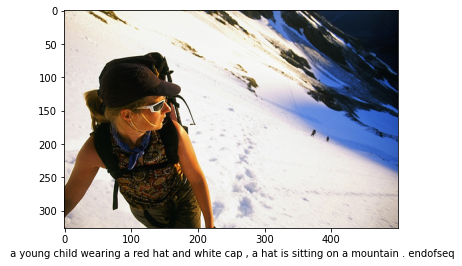

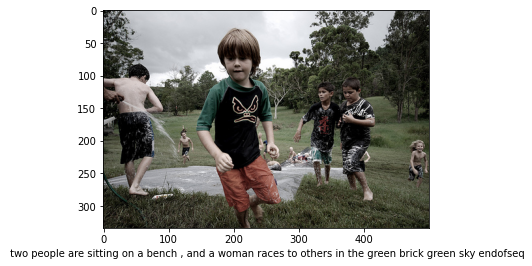

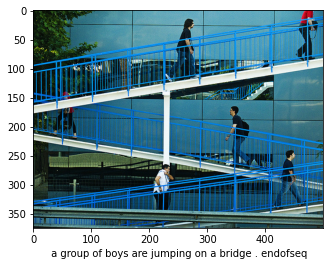

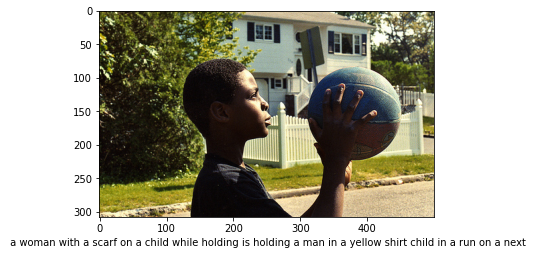

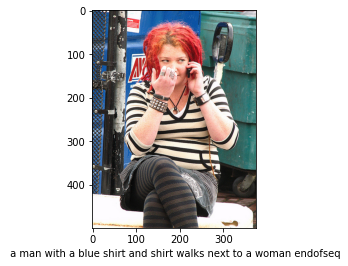

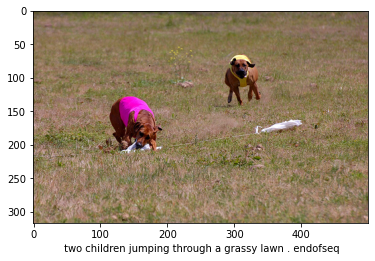

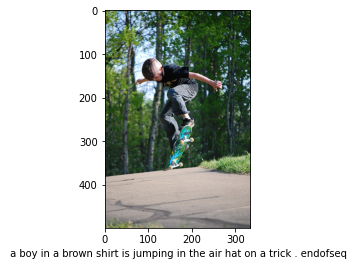

In [ ]:
for i in range(10):
    
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word
            
        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)